# Analyzing Topical Model of Facebook's Topics aiming towards Users. 

In [36]:
from __future__ import absolute_import, division, print_function
# for word vec
import gensim
from gensim.models import Word2Vec as w2v
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer

import codecs
import glob
import multiprocessing
import os
import nltk
import pprint
import re
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from ast import literal_eval # to import the column texts as list
from langdetect import detect

In [37]:
def lang_detect(s):
    try:
        return detect(s)
    except:
        return np.nan

# split into words
def get_words(raw, language):
    """
    :raw: text that has not been cleaned yet
    output: Stemmed Tokens
    """
    from nltk.tokenize import word_tokenize
    import string
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    tokens = word_tokenize(raw)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in set(stopwords.words(language))]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    return stemmed

def get_topic_distribution(lda_model, raw_input, dictionary, language):
    """Return a vecor of topical distribution of each document or text. 
    :param lda_model: the output of the function gensim.models.ldamodel.LdaModel
    :param raw_imput: raw chinese policy text or doc
    :param dictionary: the output of corpora.Dictionary() function which is the vocab.
    """
    from pandas import DataFrame
    other_texts = [ # needs tokenized
        get_words(raw_input, language)
    ]
    #dictionary = Dictionary(sentences)
    other_corpus = [dictionary.doc2bow(text) for text in other_texts]
    unseen_doc = other_corpus[0]
    vector = lda_model[unseen_doc][0]
    return(DataFrame.from_records(vector)[1])

In [38]:
import random
df = pd.read_csv('~/Code/tracking-exposed/experiments-data/eu19/dataset_eu19/user_a.csv', index_col=0)

In [39]:
df.columns

Index(['ANGRY', 'HAHA', 'LIKE', 'LOVE', 'SAD', 'WOW', 'displaySource',
       'fblinktype', 'id', 'images', 'impressionOrder', 'impressionTime',
       'nature', 'opengraph', 'permaLink', 'postId', 'publicationTime',
       'semanticCount', 'semanticId', 'source', 'sourceLink', 'texts',
       'textsize', 'timeline', 'user', 'videoautoplay'],
      dtype='object')

In [40]:
## Users
dict(df.user.groupby(df.user).count())

{'rosemary-ceviche-meringue': 10000}

In [41]:
user = 'rosemary-ceviche-meringue'

In [42]:
## Take a random sample and see language distribution
random.seed(10)
len_sample = 1000
sample = df.sample(len_sample)[['texts', 'nature', 'publicationTime']]
sample.texts = sample.texts.apply(literal_eval)

In [43]:
sample['concatLanguage'] = sample.texts.apply(''.join).apply(lang_detect)
set(sample.concatLanguage)

{'ca', 'de', 'en', 'es', 'et', 'it', nan}

In [44]:
sample.concatLanguage.groupby([sample.concatLanguage]).count()

concatLanguage
ca     79
de      1
en     23
es    892
et      1
it      3
Name: concatLanguage, dtype: int64

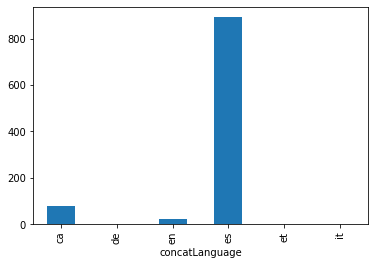

In [45]:
sample.concatLanguage.groupby([sample.concatLanguage]).count().plot(kind='bar')

In [46]:
# Subset posts with the same language and tockenize words
sample = sample[(sample.concatLanguage=='es')]
language = 'spanish'

In [47]:
# concatenate texts break into tokens for each sentence
sample['concatenatedText'] = sample.texts.apply(''.join)
import time
start = time.time()
sent = sample.concatenatedText

sentences = []
for i in sent:
    sentences.append(get_words(i, language))
end = time.time()
print(end-start, 'seconds')

18.718489170074463 seconds


In [61]:
# Set number of topics
num_topics = 3

In [65]:
import pyLDAvis.sklearn
import gensim
import os
import dill
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from gensim.models import Word2Vec as w2v
import time

# Create Dictionary
start = time.time()
id2word = corpora.Dictionary(sentences)
dictionary = Dictionary(sentences)
# Create Corpus
texts = sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           minimum_probability=0.0)

In [66]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [67]:
pyLDAvis.display(vis)
#pyLDAvis.show(vis)

In [68]:
lda_model.print_topics()

[(0,
  '0.006*"año" + 0.004*"primera" + 0.004*"españa" + 0.003*"the" + 0.003*"persona" + 0.003*"tra" + 0.003*"gobierno" + 0.003*"barcelona" + 0.003*"president" + 0.003*"partido"'),
 (1,
  '0.007*"the" + 0.006*"pp" + 0.005*"si" + 0.005*"sánchez" + 0.004*"partido" + 0.004*"candidato" + 0.004*"eleccion" + 0.004*"casado" + 0.004*"debat" + 0.004*"psoe"'),
 (2,
  '0.007*"año" + 0.004*"tre" + 0.003*"elector" + 0.003*"mosso" + 0.003*"fiscalía" + 0.003*"assang" + 0.003*"público" + 0.003*"derecho" + 0.003*"campaña" + 0.003*"referéndum"')]

## Merge the original dataset with the Topical Distribution spread 

In [69]:
import time
start = time.time()
buckets = []
for i in sample.concatenatedText:
    buckets.append(get_topic_distribution(lda_model,i,dictionary, language))
groups= []
for i in range(0,len(buckets)):
    groups.append(pd.Series.to_frame((buckets[i])).T)

groups = pd.concat(groups).reset_index()
DATA =  pd.concat([sample.reset_index(drop=True), groups],axis=1).reset_index(drop=True)
end = time.time()
print(end-start)
import dill
dill.dump_session('FBenv.db')

26.12278985977173


In [70]:
#dill.load_session('FBenv.db')

In [75]:
DATA.columns = [           'texts',           'nature',  'publicationTime',
         'concatLanguage', 'concatenatedText',            'index',
                        'Other','Politics','Advertisement']

In [76]:
#We're interested only in politics, so we sum the other columns


In [77]:
ORGANIC = DATA[DATA.nature == 'organic']
SPONSOR = DATA[DATA.nature == 'sponsored']

In [78]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pandas as pd
import math
import math
from bubbly.bubbly import add_slider_steps
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff 
import warnings
warnings.filterwarnings('ignore')
import os

ORGANIC['publicationTime']=pd.to_datetime(ORGANIC['publicationTime']).dt.date
EX = pd.DataFrame(ORGANIC.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Advertisement',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Politics',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')


data = [trace1, trace2, trace3]

layout = go.Layout(
    
    legend=dict(x=0, y=-.13,
       orientation="h")
)



# Topical Distribution Spread from Organic Posts

In [79]:
fig = go.Figure(data=data, layout=layout)
iplot(fig) 

In [80]:

EX = pd.DataFrame(SPONSOR.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Sales Ad',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Political Ad',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other Ad',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')


data = [trace1, trace2, trace3]

layout = go.Layout(
    
    legend=dict(x=0, y=-.13,
       orientation="h")
)



# Sponsored Posts Topical Spread

In [81]:
fig = go.Figure(data=data, layout=layout)
iplot(fig) 

# How much does each User's gets exposed to these Political Advertisements? 

In [82]:
# We will now ananlyze the User's exposure to these Politcal, Advertisements
user

'rosemary-ceviche-meringue'

In [84]:
USER = df[df['user']==user]
USER['publicationTime'] = pd.to_datetime(USER['publicationTime']).dt.date
USER = USER.sort_values(by='publicationTime')
USER['concatenatedText'] = USER.texts.apply(''.join)
USER = USER[['concatenatedText', 'nature', 'publicationTime']]
sent = USER.concatenatedText
sentences = []
for i in sent:
    sentences.append(get_words(i, language))

id2word = corpora.Dictionary(sentences)
dictionary = Dictionary(sentences)
# Create Corpus
texts = sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           minimum_probability=0.0)
lda_model.print_topics()

[(0,
  '0.016*"debat" + 0.014*"pp" + 0.011*"candidato" + 0.011*"partido" + 0.011*"casado" + 0.010*"sánchez" + 0.008*"vox" + 0.008*"podemo" + 0.007*"ciudadano" + 0.006*"rivera"'),
 (1,
  '0.017*"año" + 0.007*"mujer" + 0.005*"tre" + 0.004*"ser" + 0.004*"tra" + 0.004*"día" + 0.004*"persona" + 0.004*"piso" + 0.004*"detenido" + 0.004*"menor"'),
 (2,
  '0.010*"vía" + 0.007*"campaña" + 0.007*"diario" + 0.007*"público" + 0.006*"si" + 0.006*"tremend" + 0.005*"cada" + 0.005*"elector" + 0.005*"trump" + 0.005*"gobierno"')]

In [85]:
buckets = []
for i in USER.concatenatedText:
    buckets.append(get_topic_distribution(lda_model,i,dictionary, language))
groups= []
for i in range(0,len(buckets)):
    groups.append(pd.Series.to_frame((buckets[i])).T)

groups = pd.concat(groups).reset_index()
USER_DATA =  pd.concat([USER.reset_index(drop=True), groups],axis=1).reset_index(drop=True)


In [86]:
USER_DATA.columns

Index(['concatenatedText', 'nature', 'publicationTime', 'index', 0, 1, 2], dtype='object')

In [87]:
USER_DATA.columns = ['concatenatedText', 'nature', 'publicationTime', 'index', 'Advertisement', 'Other', 'Politics']

USER_ORGANIC = USER_DATA[USER_DATA.nature == 'organic']
USER_SPONSOR = USER_DATA[USER_DATA.nature == 'sponsored']

# How does Facebook impact A user's timeline impression during Political Elections?


## For $USER  Personal timeline impression exposure (below)

In [88]:
from bubbly.bubbly import add_slider_steps
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff 
import warnings
warnings.filterwarnings('ignore')
import os
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot


EX = pd.DataFrame(USER_ORGANIC.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Organic Forwarded Ads',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Organic Political Posts',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other Organic Posts',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')

data_organic = [trace1, trace2, trace3]

layout = go.Layout(

    legend=dict(x=0, y=-.13,
       orientation="h")
)

In [89]:
fig = go.Figure(data=data_organic, layout=layout)
iplot(fig) 

## Sponsored Posts for \$User:

In [90]:
EX = pd.DataFrame(USER_SPONSOR.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Sponsored Advertisement',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Sponsored Politics',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other Sponsors',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')

data_sponsored = [trace1, trace2, trace3]

layout = go.Layout(
    yaxis=dict( autorange=True,
               fixedrange = False),
    legend=dict(x=0, y=-.13,
       orientation="h")
)

In [91]:
fig = go.Figure(data=data_sponsored, layout=layout)
iplot(fig) 